# **Weather Data Analysis for Irish Locations**

## **1. Introduction**

This notebook analyses Irish weather data to explore wind speed trends and identify windfarm potential. By the end, we aim to determine which of the five analysed locations is most suitable for wind energy development.


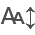

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from itables import init_notebook_mode, show
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
# Enable interactive mode for all DataFrames
init_notebook_mode(all_interactive=True)

[Reference: Pandas DataFrames as interactive HTML DataTables](https://marc-wouts.medium.com/pandas-dataframes-as-interactive-html-datatables-9737c7266abf)<br/>

---

## **2. Data Sources and File Paths**

The analysis uses weather data from five locations in Ireland: Cork, Dublin, Knock, Malin Head, and Mullingar. Data is sourced from CSV files from Met Eireann for each location

In [24]:
# File paths and corresponding locations
file_paths = [
    'data/cork_airport.csv',
    'data/dublin_airport.csv',
    'data/knock_airport.csv',
    'data/malin_head.csv',
    'data/mullingar.csv'
]
locations = ['Cork', 'Dublin', 'Knock', 'Malin Head', 'Mullingar']

[Reference: Met Eireann Historical Data](https://www.met.ie/climate/available-data/historical-data)<br/>

---

## **3. Data Loading and Preparation**

Weather data for each location is loaded from CSV files, and a 'Location' column is added to identify the source of each dataset.

In [25]:
# Load each file and add the 'Location' column
cork_data = pd.read_csv(file_paths[0], skiprows=19) 
cork_data['Location'] = 'Cork'

dublin_data = pd.read_csv(file_paths[1], skiprows=19)
dublin_data['Location'] = 'Dublin'

knock_data = pd.read_csv(file_paths[2], skiprows=19)
knock_data['Location'] = 'Knock'

malin_data = pd.read_csv(file_paths[3], skiprows=19)
malin_data['Location'] = 'Malin Head'

mullingar_data = pd.read_csv(file_paths[4], skiprows=19)
mullingar_data['Location'] = 'Mullingar'

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>

---


## **4. Consolidating Data**

Data from all locations is combined into a single dataset.The consolidated data is stored in an SQLite database for efficient querying.

#### **Column Descriptions:**
- **year**: Year  
- **month**: Month  
- **rain**: Precipitation Amount (mm)  
- **meant**: Mean Air Temperature (°C)  
- **maxtp**: Maximum Air Temperature (°C)  
- **mintp**: Minimum Air Temperature (°C)  
- **mnmax**: Mean Maximum Temperature (°C)  
- **mnmin**: Mean Minimum Temperature (°C)  
- **gmin**: Grass Minimum Temperature (°C)  
- **wdsp**: Mean Wind Speed (knot)  
- **mxgt**: Highest Gust (knot)  
- **sun**: Sunshine Duration (hours)  


In [26]:

# Concatenate all DataFrames
all_data = pd.concat([cork_data, dublin_data, knock_data, malin_data, mullingar_data], ignore_index=True)

# Save the consolidated data to an SQLite database
conn = sqlite3.connect('data/weather_data.db')
all_data.to_sql('consolidated_weather', conn, if_exists='replace', index=False)

# Confirm the data was stored correctly
print("Preview of consolidated data in SQLite:")
print(pd.read_sql_query("SELECT * FROM consolidated_weather LIMIT 5", conn))

Preview of consolidated data in SQLite:
   year  month  meant maxtp mintp  mnmax  mnmin  rain  gmin  wdsp maxgt  \
0  1962      1    5.5  11.6  -3.8    8.2    2.7        -6.3  12.8    70   
1  1962      2    5.3  12.3  -2.7    7.9    2.7        -4.4  13.6    57   
2  1962      3    4.2  12.2  -5.4    7.5    0.9        -7.2  10.3    63   
3  1962      4    7.7  18.8   0.6   11.2    4.1  68.6  -1.3  11.7    62   
4  1962      5    9.7  16.1   2.3   13.3    6.2  80.7  -0.7  12.0    45   

     sun Location  
0            Cork  
1            Cork  
2            Cork  
3  201.1     Cork  
4  216.5     Cork  


[Reference: pandas.concat() function in Python](https://www.geeksforgeeks.org/pandas-concat-function-in-python/)<br/>
[Reference: How to write Pandas dataframe to sqlite with Index](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index)<br/>
[Reference: Accessing SQLite Databases Using Python and Pandas](https://datacarpentry.github.io/python-ecology-lesson/instructor/09-working-with-sql.html)<br/>
[Reference: Pandas Read SQL Query or Table with Examples](https://sparkbyexamples.com/pandas/pandas-read-sql-query-or-table/)<br/>
[Reference: MySQL LIMIT Clause](https://www.w3schools.com/mysql/mysql_limit.asp)<br/>

In [27]:

# Query to filter data for year >= 1997 and month >= 1
query = """
SELECT * 
FROM consolidated_weather
WHERE year >= 1997 AND month >= 1
"""
analysis_weather_records = pd.read_sql_query(query, conn)

# Confirm the filtered data
print("Filtered data preview:")
print(analysis_weather_records.head())

Filtered data preview:
   year  month  meant maxtp mintp  mnmax  mnmin   rain  gmin  wdsp maxgt  \
0  1997      1    4.7  10.5  -4.4    6.3    3.2   57.4  -7.2   9.4    33   
1  1997      2    6.7  12.3   1.0    9.5    3.9  159.3  -4.4  15.5    59   
2  1997      3    8.2  15.5   0.3   11.3    5.1   31.4  -6.3   9.9    50   
3  1997      4    9.9  17.1   1.6   13.5    6.2   48.0  -7.0   7.6    40   
4  1997      5   11.2  21.7   0.2   14.9    7.5   66.1  -2.6   9.5    42   

     sun Location  
0   31.2     Cork  
1   74.7     Cork  
2  112.9     Cork  
3  164.1     Cork  
4  235.9     Cork  


[Reference: The SQL WHERE Clause](https://www.w3schools.com/sql/sql_where.asp)<br/>
[Reference: MySQL AND, OR and NOT Operators](https://www.w3schools.com/mysql/mysql_and_or.asp)<br/>

----

## **5. Handling Missing Values**

The dataset is cleaned by replacing blank entries with NaN. Missing values are analyzed by location to ensure data quality, and the cleaned data is saved to an SQLite database for further use.

In [28]:
# Replace blank fields and '-' with NaN in the filtered data
analysis_weather_records.replace([r'^\s*$'], np.nan, regex=True, inplace=True)

# Count and display missing values grouped by location
missing_values = analysis_weather_records.isnull().groupby(analysis_weather_records['Location']).sum()
print("Missing values by column and location:")
print(missing_values)

Missing values by column and location:
            year  month  meant  maxtp  mintp  mnmax  mnmin  rain  gmin  wdsp  \
Location                                                                       
Cork           0      0      0      0      0      0      0     0     0     0   
Dublin         0      0      0      0      0      0      0     0     1     0   
Knock          0      0      0      0      0      0      0     0     0     0   
Malin Head     0      0      0      0      0      0      0     0     0     1   
Mullingar      0      0      0      0      0      0      0     0     1     2   

            maxgt  sun  Location  
Location                          
Cork            0    0         0  
Dublin          0    0         0  
Knock           3   55         0  
Malin Head      0  166         0  
Mullingar       4  214         0  



[Reference: Replace values in Pandas dataframe using regex](https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/)<br/>
[Reference: Pandas: How to Replace Zero with NaN](https://www.statology.org/pandas-replace-0-with-nan/)<br/>
[Reference: A Guide to R Regular Expressions](https://www.datacamp.com/tutorial/regex-r-regular-expressions-guide) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>
[Reference: pd.NA vs np.nan for pandas](https://stackoverflow.com/questions/60115806/pd-na-vs-np-nan-for-pandas)<br/>



#### **Overview of Missing Data:**  
- **Data Gaps:**  
  - `sun`: Missing from Mullingar (2007), Malin Head (2011), Knock (2020).  

- **Location Soecific Gaps:**  
  - Dublin: 1 `gmin` value missing.  
  - Mullingar: 1 `gmin`, 2 `wsdp`, and 4 `maxgt` values missing.  
  - Malin Head: 1 `wdsp` value missing.  
  - Knock: 4 `maxgt` values missing.  

- **Exclusions from Analysis**:
  - The `sun` and `gmin` columns will be excluded from the analysis as they are not relevant to the goals of this project.
  - Three missing `wdsp` values will be dropped, as it is negligible in the overall dataset.

In [29]:
# Display the data types of all columns to verify they are correctly formatted for analysis
print(analysis_weather_records.dtypes)

year          int64
month         int64
meant       float64
maxtp        object
mintp        object
mnmax       float64
mnmin       float64
rain         object
gmin         object
wdsp         object
maxgt        object
sun          object
Location     object
dtype: object


In [30]:
# Convert selected columns to numeric data types, coercing invalid entries to NaN for cleaning
columns_to_convert = ['maxtp', 'mintp', 'rain', 'gmin', 'wdsp', 'maxgt', 'sun']
for col in columns_to_convert:
    analysis_weather_records[col] = pd.to_numeric(analysis_weather_records[col], errors='coerce')

[Reference: pandas: to_numeric for multiple columns](https://stackoverflow.com/questions/36814100/pandas-to-numeric-for-multiple-columns)<br/>

In [31]:
# Check the data types of all columns after conversion to ensure they are now correctly formatted
print(analysis_weather_records.dtypes)

year          int64
month         int64
meant       float64
maxtp       float64
mintp       float64
mnmax       float64
mnmin       float64
rain        float64
gmin        float64
wdsp        float64
maxgt       float64
sun         float64
Location     object
dtype: object


In [32]:
# Drop rows where 'wdsp' (wind speed) values are missing
cleaned_weather_records = analysis_weather_records.dropna(subset=['wdsp']).reset_index(drop=True)

[Reference: Pandas: How to Use dropna() with Specific Columns](https://www.statology.org/pandas-dropna-specific-column/)<br/>

In [33]:
# Save the cleaned dataset to a new SQLite table for reuse
conn = sqlite3.connect('data/weather_data.db')
cleaned_weather_records.to_sql('cleaned_weather', conn, if_exists='replace', index=False)
print("\nCleaned dataset saved as 'cleaned_weather' in SQLite database.")


Cleaned dataset saved as 'cleaned_weather' in SQLite database.


[Reference: How to write Pandas dataframe to sqlite with Index](https://stackoverflow.com/questions/14431646/how-to-write-pandas-dataframe-to-sqlite-with-index)<br/>

---

## **6. Monthly Wind Speed Over Time by Location**


This section analyses monthly mean wind speeds for each location, visualized through line plots, to assess consistency and suitability for windfarm development.

#### **Line plot with markers showing the monthly mean wind speed for each location.**

In [34]:

# Extract relevant columns and create a copy to avoid modifying the original DataFrame
monthly_windspeed_data = cleaned_weather_records[['Location', 'year', 'month', 'wdsp']].copy()

# Add a 'date' column and convert to datetime
monthly_windspeed_data['date'] = pd.to_datetime(
    monthly_windspeed_data[['year', 'month']].assign(day=1)
)

# Create subplots for each location
locations = monthly_windspeed_data['Location'].unique()
fig = make_subplots(
    rows=len(locations), cols=1, shared_xaxes=True,
    subplot_titles=[f"Average Windspeed - {loc}" for loc in locations]
)

# Plot wind speed trends for each location
for i, location in enumerate(locations):
    fig.add_trace(
        go.Scatter(
            x=monthly_windspeed_data[monthly_windspeed_data['Location'] == location]['date'],
            y=monthly_windspeed_data[monthly_windspeed_data['Location'] == location]['wdsp'],
            mode='lines+markers',
            name=location
        ),
        row=i + 1, col=1
    )

# Configure figure layout and shared axis settings
fig.update_layout(
    height=300 * len(locations),
    
    template="plotly_white",
    showlegend=False
)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Average Windspeed (knots)")

# Render the final plot
fig.show()






[Reference: Plotly- Subplots in Python](https://plotly.com/python/subplots/)<br/>
[Reference:Plotly- Scatter Plots in Python ](https://plotly.com/python/line-and-scatter/)<br/>
[Reference:Plotly- Python Figure Reference: layout ](https://plotly.com/python/reference/layout/)<br/>
[Reference:Plotly-Python Figure Reference: layout.xaxis ](https://plotly.com/python/reference/layout/xaxis/)<br/>
[Reference:Python Figure Reference: layout.yaxis ](https://plotly.com/python/reference/layout/yaxis/#:~:text=Python%20Figure%20Reference%3A%20layout.,yaxis&text=Type%3A%20dict%20containing%20one%20or%20more%20of%20the%20keys%20listed%20below.&text=If%20set%20to%20an%20opposite,the%20corresponding%20opposite%2Dletter%20axis.)<br/>
[Reference: Pandas DataFrame copy() Method](https://www.w3schools.com/python/pandas/ref_df_copy.asp)<br/>
[Reference: Pandas DataFrame assign() Method | Create new Columns in DataFrame](https://www.geeksforgeeks.org/pandas-dataframe-assign/)<br/>
[Reference: How to Specify Format in pandas.to_datetime](https://www.statology.org/pandas-to-datetime-format/) <br/>
[Reference: The Basics of the Python Enumerate() Function](https://blog.hubspot.com/website/python-enumerate)<br/>

#### **Monthly Wind Speed Over Time by Location Analysis**

 **Cork**:  
   - **Range**: 6.1–15 knots (Highest: Feb 1997).  
   - Generally steady with winter spikes.  

 **Dublin**:  
   - **Range**: 6.5–16.4 knots (Highest: Feb 1997).  
   - Slight decline since 2018, with winter spikes.  

 **Knock**:  
   - **Range**: 6.1–15 knots (Highest: Feb 1997).  
   - Generally steady with winter spikes.  

 **Malin Head**:  
   - **Range**: 7.8–22.9 knots (Highest: Feb 1997).  
   - Largest seasonal variance, frequent winter spikes.  

 **Mullingar**:  
   - **Range**: 3.6–11.2 knots (Highest: Feb 1997).  
   - Generally steady with winter spikes.  
 
All locations recorded their highest windspeed in February 1997, highlighting a significant weather event. Malin Head's strong, variable winds could make it ideal for wind farms, while Cork, Dublin, Knock, and Mullingar offer steadier but moderate wind energy potential.

----

## **7. Seasonal Windspeed by Location**


This section examines average wind speeds by season for each location, highlighting seasonal patterns and their impact on wind energy potential. Insights are visualized using bar plots.

In [35]:
# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add a 'season' column to the DataFrame
monthly_windspeed_data['Season'] = monthly_windspeed_data['month'].apply(get_season)

# Group by Location and Season, and calculate the mean windspeed
seasonal_windspeed_summary = (
    monthly_windspeed_data
    .groupby(['Location', 'Season'])['wdsp']
    .mean()
    .reset_index()
    .sort_values(by=['Location', 'Season'])
)
# Rename the columns for clarity
seasonal_windspeed_summary.columns = ['Location', 'Season', 'Average Windspeed']

# Display the summary table
display(seasonal_windspeed_summary)



Location  Season  Average Windspeed
0         Cork  Autumn           9.506024
1         Cork  Spring           9.834524
2         Cork  Summer           8.653571
3         Cork  Winter          10.816867
4       Dublin  Autumn          10.240964
5       Dublin  Spring          10.194048
6       Dublin  Summer           9.055952
7       Dublin  Winter          11.739759
8        Knock  Autumn           9.246988
9        Knock  Spring           9.547619
10       Knock  Summer           8.422619
11       Knock  Winter          10.595181
12  Malin Head  Autumn          15.578313
13  Malin Head  Spring          14.247619
14  Malin Head  Summer          12.110843
15  Malin Head  Winter          17.514458
16   Mullingar  Autumn           6.259036
17   Mullingar  Spring           6.591667
18   Mullingar  Summer           5.586585
19   Mullingar  Winter           7.226506

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>
[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>

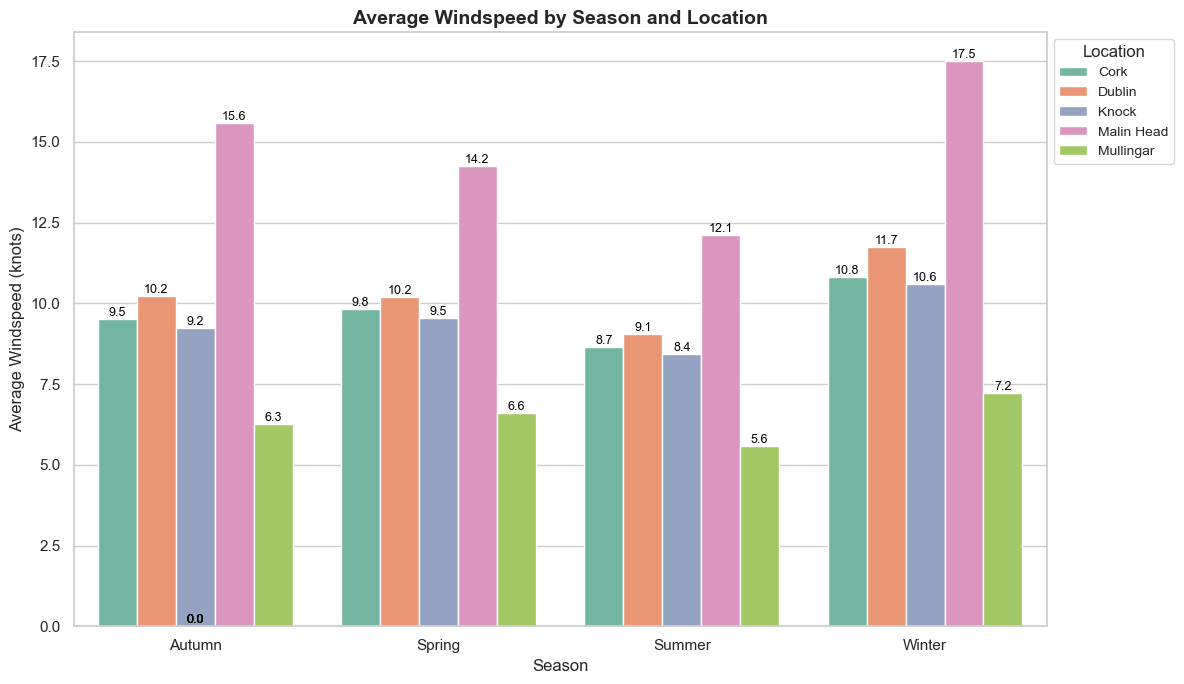

In [36]:
# Select the correct number of colors
num_locations = seasonal_windspeed_summary['Location'].nunique()
palette = sns.color_palette("Set2", n_colors=num_locations)  # Use only required colors

# Updated bar plot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")
ax = sns.barplot(
    data=seasonal_windspeed_summary,
    x='Season',
    y='Average Windspeed',
    hue='Location',
    palette=palette
)

# Add annotations
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=9, color='black')

# Labels and legend
plt.title("Average Windspeed by Season and Location", fontsize=14, weight='bold')
plt.xlabel("Season", fontsize=12)
plt.ylabel("Average Windspeed (knots)", fontsize=12)
plt.legend(title="Location", loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)

plt.tight_layout()
plt.show()


[Reference: Grouped Barplot using Seaborn](https://python-graph-gallery.com/grouped-barplot/)<br/>
[Reference: Annotate bars with values on Pandas bar plots](https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots)<br/>
[Reference: How To Annotate Bars in Barplot with Matplotlib in Python?](https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/)<br/>

#### **Seasonal Windspeed by Location Analysis**
Winter provides the highest wind energy potential, while summer has the lowest. Coastal locations like Malin Head and Dublin overall perform best, highlighting the importance of site selection. Seasonal variability may highlight the need for strategies to manage lower summer output.

---

## **8. Yearly windspeed summary by location and Windfarm Location Suitability**


This section analyses yearly windspeed trends for each location, calculating mean, median, and variance to assess consistency and strength for wind farm suitability.

In [37]:
# Group by Location and Year, and calculate summary statistics
yearly_windspeed_summary = (
    monthly_windspeed_data
    .groupby(['Location', 'year'])['wdsp']
    .agg(['mean', 'median', 'var'])
    .reset_index()
)

# Rename the columns for clarity
yearly_windspeed_summary.columns = ['Location', 'Year', 'Mean Windspeed', 'Median Windspeed', 'Variance']


# Display table
show(yearly_windspeed_summary)


[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Pandas Series agg() Method](https://www.geeksforgeeks.org/python-pandas-series-agg/)
<br/>

Wind turbines **start operating** at **Beaufort Force 3**, reach **maximum power** at **Force 5**, and **shut down** at Storm **Force 10** to prevent damage
<br/>
[Source: Irish Wind Energy Association](http://www.iwea.ie/technicalfaqs#:~:text=Turbines%20reach%20maximum%20power%20output,prevent%20excessive%20wear%20and%20tear.)
<br/>
| Beaufort Rating | Wind Speed (Knots) |
|-----------------|--------------------|
| 0               | < 1                |
| 1               | 1–3                |
| 2               | 4–6                |
| 3               | 7–10               |
| 4               | 11–16              |
| 5               | 17–21              |


[Source: Met Eireann](https://www.met.ie/cms/assets/uploads/2022/09/Beaufort-scale-for-land.png)
<br/>

In [38]:
# Group by Location and calculate summary statistics
location_summary = yearly_windspeed_summary.groupby('Location').agg(
    Mean_Windspeed_Min=('Mean Windspeed', 'min'),
    Mean_Windspeed_Max=('Mean Windspeed', 'max'),
    Variance_Avg=('Variance', 'mean')
).reset_index()

def classify_windspeed(row):
    
    max_wind_knots = row['Mean_Windspeed_Max']
    min_wind_knots = row['Mean_Windspeed_Min']
    wind_variance = row['Variance_Avg']
    
    # Strong winds: Beaufort 5 and above (17+ knots)
    if max_wind_knots >= 17:
        if wind_variance < 3:
            return "Strong and stable winds, turbines reach maximum power."
        else:
            return "Strong but variable winds, turbines reach maximum power."
    
    # Moderate winds: Beaufort 4 (11–16 knots)
    elif max_wind_knots >= 11:
        if min_wind_knots >= 7 and wind_variance < 3:
            return "Moderate and stable winds, turbines operate efficiently."
        else:
            return "Moderate but variable winds, suitable for energy generation."
    
    # Gentle winds: Beaufort 3 (7–10 knots)
    elif max_wind_knots >= 7:
        return "Gentle winds, turbines are operational but efficiency is limited."
    
    # Low winds: Below Beaufort 3 (< 7 knots)
    else:
        return "Low winds, turbines are not operational."


# Apply the updated classification
location_summary['Analysis'] = location_summary.apply(classify_windspeed, axis=1)

# Display the summarized table
display(location_summary)


Location  Mean_Windspeed_Min  Mean_Windspeed_Max  Variance_Avg  \
0        Cork            8.975000           10.366667      2.249477   
1      Dublin            8.641667           11.541667      3.134079   
2       Knock            8.358333           10.200000      2.251128   
3  Malin Head           12.933333           16.525000      8.780041   
4   Mullingar            5.208333            7.490909      1.296408   

                                            Analysis  
0  Gentle winds, turbines are operational but eff...  
1  Moderate but variable winds, suitable for ener...  
2  Gentle winds, turbines are operational but eff...  
3  Moderate but variable winds, suitable for ener...  
4  Gentle winds, turbines are operational but eff...

[Reference:How to reset index after Groupby pandas?](https://www.geeksforgeeks.org/how-to-reset-index-after-groupby-pandas/) <br/>
[Reference: Using isnull() and groupby() on a pandas dataframe](https://stackoverflow.com/questions/46106954/using-isnull-and-groupby-on-a-pandas-dataframe)<br/>
[Reference: Pandas Series agg() Method](https://www.geeksforgeeks.org/python-pandas-series-agg/)
<br/>
[Reference: Pandas Apply: 12 Ways to Apply a Function to Each Row in a DataFrame](https://www.ml4devs.com/articles/pandas-dataframe-apply-function-iterate-over-rows/)
<br/>

#### **Yearly Average Windspeed Analysis**

Malin Head offers the strongest winds and highest variability, making it ideal for wind energy. Dublin shows high potential with some variability, while Cork and Knock provide steady but moderate winds. Mullingar’s low windspeeds make it less suitable for wind farms. As observed in Section 7 Coastal locations clearly outperform inland areas.

---

## **9.Predicting Future Wind Trends**

This section forecasts wind speeds for all locations, eventually focusing on Malin Head and Dublin—the top sites for wind energy potential—using linear regression and SARIMAX models to assess their long-term suitability for wind farms.

#### **Linear regression**

Linear regression models the relationship between time and wind speed, making it useful for an initial assessment of wind patterns.

In [39]:
# Create a 'date' column by combining 'year' and 'month', setting the day to 1
monthly_windspeed_data['date'] = pd.to_datetime(monthly_windspeed_data[['year', 'month']].assign(day=1)
)

# Convert 'date' to a numeric format for linear regression model
monthly_windspeed_data['date_numeric'] = monthly_windspeed_data['date'].map(pd.Timestamp.toordinal)

# Get unique locations from the dataset
locations = monthly_windspeed_data['Location'].unique()

[Reference: Add column with constant value to pandas dataframe](https://www.geeksforgeeks.org/add-column-with-constant-value-to-pandas-dataframe/)<br/>
[Reference: Python: Linear regression from Pandas df - ordinal dates conversion](https://stackoverflow.com/questions/66720622/python-linear-regression-from-pandas-df-ordinal-dates-conversion)<br/>

In [40]:

for location in locations:
    # Filter data for the current location
    location_data = monthly_windspeed_data[monthly_windspeed_data['Location'] == location]

    # Define features and target
    X = location_data[['date_numeric']]
    y = location_data['wdsp']

    # Split the data into training (80%) and testing (20%)
    split_date = location_data['date'].quantile(0.8)
    train_data = location_data[location_data['date'] <= split_date]
    test_data = location_data[location_data['date'] > split_date]

    X_train, y_train = train_data[['date_numeric']], train_data['wdsp']
    X_test, y_test = test_data[['date_numeric']], test_data['wdsp']

    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Location: {location} | Mean Absolute Error: {mae}")




Location: Cork | Mean Absolute Error: 1.10809464181946
Location: Dublin | Mean Absolute Error: 2.048103851412383
Location: Knock | Mean Absolute Error: 1.0284103845237575
Location: Malin Head | Mean Absolute Error: 2.2712742725512363
Location: Mullingar | Mean Absolute Error: 0.7995176089631472


[Reference: python linear regression predict by date](https://stackoverflow.com/questions/40217369/python-linear-regression-predict-by-date)<br/>
[Reference: Linear Regression in Python](https://realpython.com/linear-regression-in-python/)<br/>
[Reference: Pandas date_range to generate monthly data at beginning of the month](https://stackoverflow.com/questions/34915828/pandas-date-range-to-generate-monthly-data-at-beginning-of-the-month)<br/>
[Reference: Splitting data using time-based splitting in test and train datasets](https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets)<br/>
[Reference: Pandas quantile()](https://www.programiz.com/python-programming/pandas/methods/quantile#:~:text=Add%20two%20numbers-,Pandas%20quantile.)<br/>
[Reference: Split dataframe into two on the basis of date](https://stackoverflow.com/questions/37532098/split-dataframe-into-two-on-the-basis-of-date)<br/>
[Reference: Split Your Dataset With scikit-learn's train_test_split()](https://realpython.com/train-test-split-python-data/)<br/>
[Reference: How to Calculate Mean Absolute Error in Python](https://www.statology.org/mean-absolute-error-python/)<br/>



### Linear Regression Analysis

MAE measures the average error between predicted and actual values, providing a straightforward metric for accuracy. However, high variability in **Dublin** and **Malin Head**, caused by seasonal spikes, has disrupted linear regression predictions.

Time-based splits and numeric date features were applied to improve accuracy, but I will proceed to try a model that handles outliers and variances more effectively.

As proved earlier, **Dublin** and **Malin Head** are the most viable locations for a windfarm. I will focus on finding a model that more accurately predicts future wind speeds for these two locations specifically. 


[Reference: Regression Metrics for Machine Learning)](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)<br/>
[Reference: Mastering Mean Absolute Error: A Beginner's Guide to Evaluating Regression Models)](https://the-pi-guy.com/blog/mastering_mean_absolute_error_a_beginners_guide_to_evaluating_regression_models/)<br/>

## Time series forcasting with SAIRMAX

In [41]:
# Load the cleaned_weather table
query_cleaned = "SELECT * FROM cleaned_weather;"
cleaned_weather = pd.read_sql_query(query_cleaned, conn)

Location: Dublin | Mean Absolute Error (MAE): 0.9971667869551819


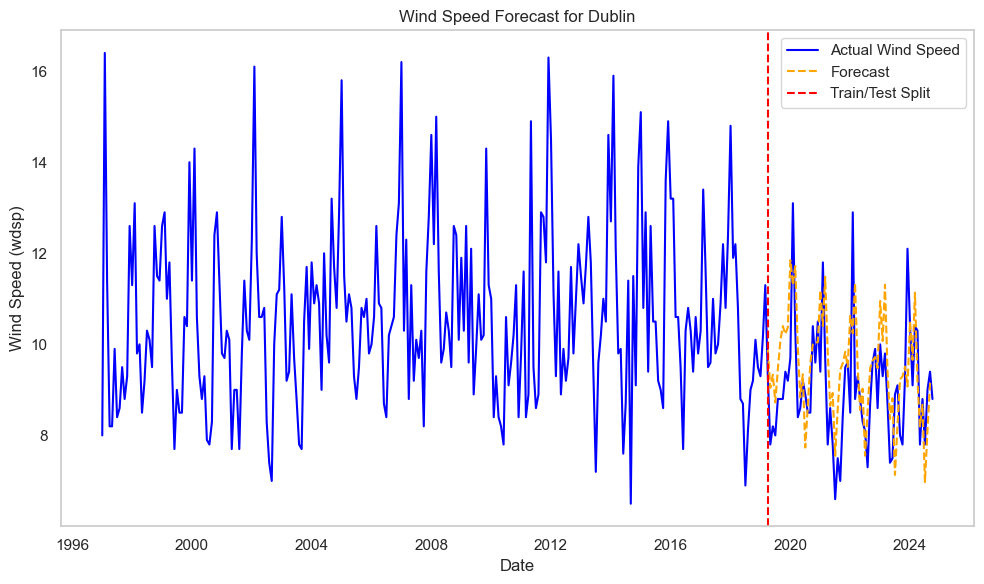

Location: Malin Head | Mean Absolute Error (MAE): 1.4306284358235362


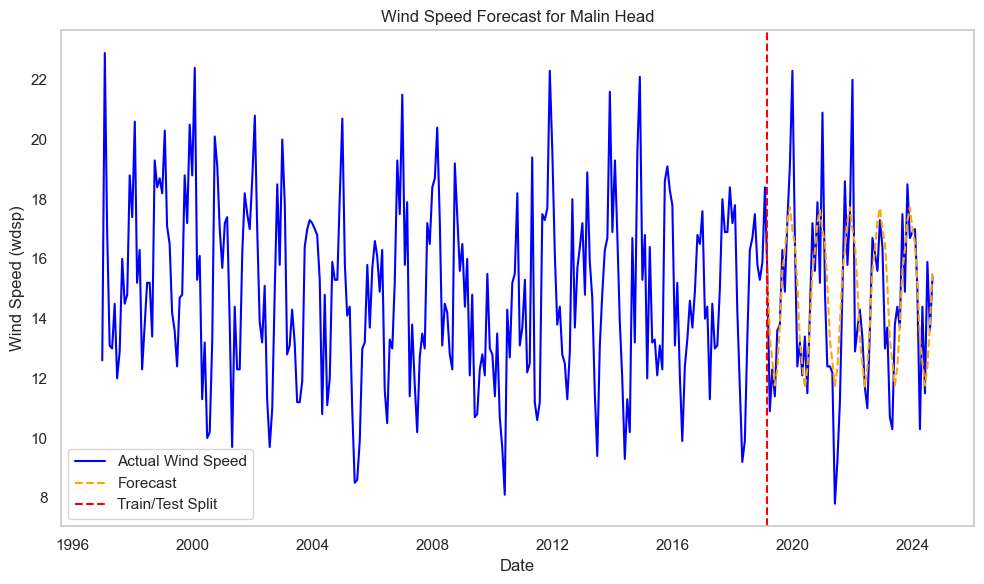

In [42]:
locations = {
    "Dublin": {
        "arima_order": (1, 1, 1),
        "seasonal_order": (2, 2, 2, 12)
    },
    "Malin Head": {
        "arima_order": (1, 1, 1),
        "seasonal_order": (2, 1, 2, 12)
    }
}

for location, params in locations.items():
    # Filter data for the current location and select relevant columns
    location_data = cleaned_weather[cleaned_weather['Location'] == location][['year', 'month', 'wdsp']].copy()

    # Create a datetime index using 'year' and 'month'
    location_data['date'] = pd.to_datetime(location_data[['year', 'month']].assign(day=1))
    location_data.set_index('date', inplace=True)

    # Ensure the index has a consistent frequency (monthly start)
    location_data.index = pd.date_range(start=location_data.index[0], periods=len(location_data), freq='MS')

    # Split the data into training (80%) and testing (20%)
    split_date = location_data.index[int(len(location_data) * 0.8)]
    train_data = location_data[location_data.index < split_date]
    test_data = location_data[location_data.index >= split_date].copy()  # Create a copy to avoid SettingWithCopyWarning

    # Fit a SARIMA model to the training data
    seasonal_model = SARIMAX(
        train_data['wdsp'], 
        order=params['arima_order'],  # Use individual ARIMA order for the location
        seasonal_order=params['seasonal_order'],  # Use individual seasonal order for the location
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    seasonal_fit = seasonal_model.fit(disp=False)  # Suppress long output

    # Generate forecasts for the test set
    test_data['Forecast'] = seasonal_fit.forecast(steps=len(test_data))

    # Calculate the Mean Absolute Error
    mae = mean_absolute_error(test_data['wdsp'], test_data['Forecast'])

    # Print the results
    print(f"Location: {location} | Mean Absolute Error (MAE): {mae}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(location_data.index, location_data['wdsp'], label='Actual Wind Speed', color='blue')
    plt.plot(test_data.index, test_data['Forecast'], label='Forecast', color='orange', linestyle='--')
    plt.axvline(x=split_date, color='red', linestyle='--', label='Train/Test Split')
    plt.title(f"Wind Speed Forecast for {location}")
    plt.xlabel('Date')
    plt.ylabel('Wind Speed (wdsp)')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()



[Reference: Complete Guide To SARIMAX in Python](https://www.geeksforgeeks.org/complete-guide-to-sarimax-in-python/)<br/>
[Reference: Seasonality and SARIMAX](https://www.kaggle.com/code/nholloway/seasonality-and-sarimax)<br>
[Reference: Forecasting Time Series Data with SARIMAX: A Step-by-Step Guide](https://medium.com/pythonforall/forecasting-time-series-data-with-sarimax-a-step-by-step-guide-701bffc990dd)<br/>
[Reference: How to Create an Index for Python Pandas DataFrame: A Guide](https://saturncloud.io/blog/how-to-create-an-index-for-python-pandas-dataframe-a-comprehensive-guide/)<br/>
[Reference: Step-by-Step Guide to Time Series Forecasting with SARIMA Models](https://mlpills.dev/time-series/how-to-train-a-sarima-model-step-by-step/)<br/>
[Reference: Step-by-Step Guide to Time Series Forecasting with SARIMA Models](https://mlpills.dev/time-series/how-to-train-a-sarima-model-step-by-step/)<br/>
[Reference: Three techniques to improve SARIMAX model for time series forecasting](https://medium.com/@poudel.birat25/three-techniques-to-improve-sarimax-model-for-time-series-forecasting-5d48db984fbe/)<br/>
[Reference: Forecasting in statsmodels](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_forecasting.html)<br/>
[Reference: Pandas DataFrame copy() Method](https://www.w3schools.com/python/pandas/ref_df_copy.asp)<br/>
[Reference: Pandas date_range to generate monthly data at beginning of the month](https://stackoverflow.com/questions/34915828/pandas-date-range-to-generate-monthly-data-at-beginning-of-the-month)<br/>
[Reference: Splitting data using time-based splitting in test and train datasets](https://stackoverflow.com/questions/50879915/splitting-data-using-time-based-splitting-in-test-and-train-datasets)<br/>
[Reference: How to Calculate Mean Absolute Error in Python](https://www.statology.org/mean-absolute-error-python/)<br/>


### SARIMAX Analysis

I tested different SARIMA parameters and found that Dublin and Malin Head needed different settings for the best results. For Dublin, the model had an MAE of 0.997, showing it predicts wind speeds very accurately, with errors around 1 unit. For Malin Head, the MAE was 1.43, which is still good considering the larger variability in wind speeds there. I will now use this model to predict wind speeds for the next 10 years.

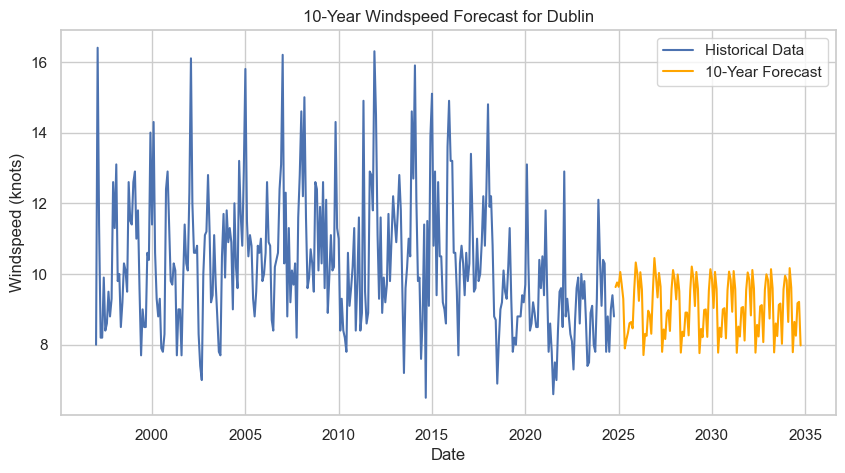

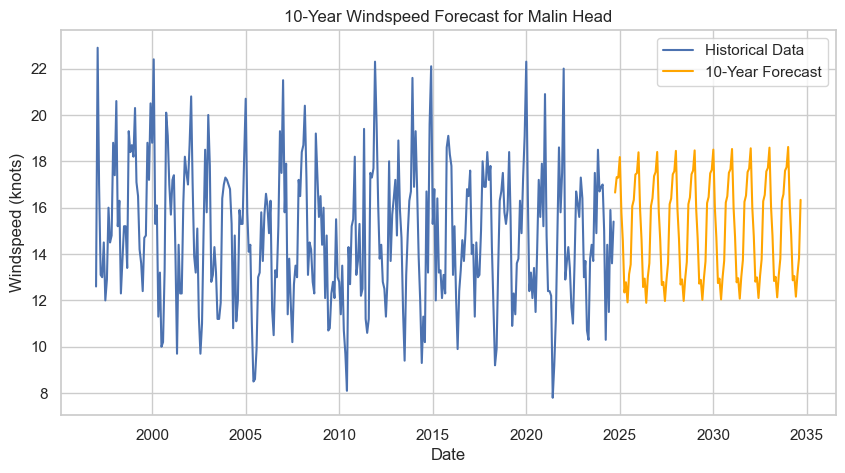

In [43]:
forecast_years = 10
forecast_steps = forecast_years * 12  # 10 years of monthly data

locations = {
    "Dublin": {
        "arima_order": (1, 1, 1),
        "seasonal_order": (2, 2, 2, 12)
    },
    "Malin Head": {
        "arima_order": (2, 1, 0),
        "seasonal_order": (2, 1, 2, 12)
    }
}

for location, params in locations.items():
    # Filter data for the current location and select relevant columns
    location_data = cleaned_weather[cleaned_weather['Location'] == location][['year', 'month', 'wdsp']].copy()

    # Create a datetime index using 'year' and 'month'
    location_data['date'] = pd.to_datetime(location_data[['year', 'month']].assign(day=1))
    location_data.set_index('date', inplace=True)

    # Ensure the index has a consistent frequency (monthly start)
    location_data.index = pd.date_range(start=location_data.index[0], periods=len(location_data), freq='MS')

    # Fit a SARIMA model to the entire dataset
    seasonal_model = SARIMAX(
        location_data['wdsp'], 
        order=params['arima_order'],  # Use individual ARIMA order for the location
        seasonal_order=params['seasonal_order'],  # Use individual seasonal order for the location
        enforce_stationarity=False, 
        enforce_invertibility=False
    )
    seasonal_fit = seasonal_model.fit(disp=False)  # Suppress long output

    # Generate forecasts for the next 10 years
    forecast_values = seasonal_fit.forecast(steps=forecast_steps)

    # Generate the index for the forecasted dates
    forecast_index = pd.date_range(
        start=location_data.index[-1] + pd.DateOffset(months=1), 
        periods=forecast_steps, 
        freq='MS'
    )

    # Plot the historical data and forecast
    plt.figure(figsize=(10, 5))
    plt.plot(location_data['wdsp'], label='Historical Data')
    plt.plot(forecast_index, forecast_values, label='10-Year Forecast', color='orange')
    plt.title(f"10-Year Windspeed Forecast for {location}")
    plt.xlabel("Date")
    plt.ylabel("Windspeed (knots)")
    plt.legend()
    plt.show()


[Reference: How to Use Seasonal ARIMA (SARIMA) for Time Series Forecasting in Python](https://www.statology.org/how-to-use-seasonal-arima-sarima-for-time-series-forecasting-in-python/)<br/>
[Reference: Time Series Forecasting with Python](https://www.blog.trainindata.com/time-series-forecasting-python/)<br/>

---

In [44]:
# Close the SQLite connection
conn.close()
